In [50]:
suppressPackageStartupMessages(library(readxl))
suppressPackageStartupMessages(library(dplyr))
suppressPackageStartupMessages(library(tidyr))
suppressPackageStartupMessages(library(tibble))
suppressPackageStartupMessages(library(patchwork))
suppressPackageStartupMessages(library(pheatmap))
suppressPackageStartupMessages(library(stringr))
library(hise)
library(plyr)
library(purrr)
library(vegan)
#library(arrow)
library(rstatix)
library(parallel)
library(ggpubr)
library(ComplexHeatmap)
library(compositions)
library(ggsci)
library(math)

ERROR: Error in library(compositions): there is no package called ‘compositions’


In [1]:
colors = c('#FDC086','#FFFF99','#F0027F','#BF5B17','#666666',
          '#1B9E77','#D95F02','#7570B3','#E7298A','#66A61E','#E6AB02','#A6761D','#666666',
          '#A6CEE3','#1F78B4','#B2DF8A','#33A02C','#FB9A99','#E31A1C','#FDBF6F','#FF7F00',
          '#CAB2D6','#6A3D9A','#FFFF99','#B15928','#FBB4AE','#B3CDE3','#CCEBC5','#DECBE4',
          '#FED9A6','#FFFFCC','#E5D8BD','#FDDAEC','#F2F2F2','#B3E2CD','#FDCDAC','#CBD5E8',
          '#F4CAE4','#E6F5C9','#FFF2AE','#F1E2CC','#CCCCCC','#E41A1C','#377EB8','#4DAF4A',
          '#984EA3','#FF7F00','#FFFF33','#A65628','#F781BF','#999999','#66C2A5','#FC8D62',
          '#8DA0CB','#E78AC3','#A6D854','#FFD92F','#E5C494','#B3B3B3','#8DD3C7','#FFFFB3',
          '#BEBADA','#FB8072','#80B1D3','#FDB462','#B3DE69','#FCCDE5','#D9D9D9','#BC80BD',
          '#CCEBC5','#FFED6F')

# Reading the file

In [3]:
# Read the CSV file into a data frame
myeloid_df <- read.csv('/home/jupyter/Myeloid_cells/files/Parquet_files/AIFI_Reference_processed.csv')


In [4]:
#remove UPI from the cohort
myeloid_df <- myeloid_df %>% filter(cohort.cohortGuid != 'UP1')

In [ ]:
head(myeloid_df)

In [ ]:
colnames(myeloid_df)

In [5]:
rownames(myeloid_df)<-myeloid_df$cell_uuid

# CLR Transform


In [26]:
clr_transform <- function(x) {
  if (length(x) == 0) {
    return(NA)  # return NA for empty vectors
  }
  geom_mean <- exp(mean(log(x)))
  return(log(x / geom_mean))
}

# Comparsion within total PBMCs (Percentage - mean difference)

In [27]:
## Percentage of total

result <- myeloid_df %>%
  dplyr::group_by(AIFI_L3, subject.subjectGuid ) %>%               
  dplyr::summarise(count = n()) %>%                  # Count occurrences
  dplyr::group_by(subject.subjectGuid) %>%                       
  dplyr::mutate(percentage = (count / sum(count)) * 100) %>% 
  dplyr::group_by(subject.subjectGuid) %>%     
  dplyr::mutate(percentage_clr = clr_transform((percentage))) %>% # Group again by subjectGuid for CLR# Calculate percentage
  dplyr::ungroup()

head(result)
#sum(result$subject.subjectGuid)

`summarise()` has grouped output by 'AIFI_L3'. You can override using the
`.groups` argument.


AIFI_L3,subject.subjectGuid,count,percentage,percentage_clr
<chr>,<chr>,<int>,<dbl>,<dbl>
ASDC,BR1001,6,0.03236770,-2.232976
ASDC,BR1002,5,0.02637409,-2.242500
ASDC,BR1003,4,0.02094680,-2.763896
ASDC,BR1004,3,0.01710571,-2.626914
ASDC,BR1005,5,0.02809620,-1.943233
ASDC,BR1006,4,0.02300966,-2.337902


In [ ]:
result %>% filter(subject.subjectGuid == "BR1001") %>% 
      select(percentage) %>%
      pull() %>% 
      sum()

In [28]:
result<-left_join(result,unique(myeloid_df[c('cohort.cohortGuid','subject.subjectGuid','subject.biologicalSex','CMV.IgG.Serology.Result.Interpretation')]),by=c('subject.subjectGuid'))

In [ ]:
head(result)

In [ ]:
# library(dplyr)

# # Assuming your data frame is named 'your_data'
# result_df <- result %>%
#   dplyr::group_by(AIFI_L3, cohort.cohortGuid, CMV.IgG.Serology.Result.Interpretation) %>%
#   dplyr::summarise(mean_percentage = mean(percentage)) %>%
#   tidyr::pivot_wider(names_from = CMV.IgG.Serology.Result.Interpretation, values_from = mean_percentage) %>%
#   dplyr::mutate(Mean_Diff_BR1 = Positive - Negative,
#          Mean_Diff_BR2 = Positive - Negative) %>%
#   dplyr::select(AIFI_L3, cohort.cohortGuid, Mean_Diff_BR1, Mean_Diff_BR2)

# # Print the result
# print(result_df)


In [ ]:
#BY CMV seperation

library(dplyr)
library(tidyr)

# Assuming your data frame is named 'your_data'
result_df <- result %>%
  dplyr::group_by(AIFI_L3, CMV.IgG.Serology.Result.Interpretation, cohort.cohortGuid) %>%
  dplyr::summarise(mean_percentage = mean(percentage)) 

# Print the result
print(result_df)

In [64]:
#without CMV seperation

library(dplyr)
library(tidyr)

# Assuming your data frame is named 'your_data'
result_df <- result %>%
  dplyr::group_by(AIFI_L3, CMV.IgG.Serology.Result.Interpretation) %>%
  dplyr::summarise(mean_percentage = mean(percentage)) 

# Print the result
print(result_df)

`summarise()` has grouped output by 'AIFI_L3'. You can override using the
`.groups` argument.


# A tibble: 142 × 3
# Groups:   AIFI_L3 [71]
   AIFI_L3                 CMV.IgG.Serology.Result.Interpretat…¹ mean_percentage
   <chr>                   <chr>                                           <dbl>
 1 ASDC                    Negative                                      0.0222 
 2 ASDC                    Positive                                      0.0252 
 3 Activated memory B cell Negative                                      0.0250 
 4 Activated memory B cell Positive                                      0.0272 
 5 Adaptive NK cell        Negative                                      0.243  
 6 Adaptive NK cell        Positive                                      1.72   
 7 BaEoMaP cell            Negative                                      0.00832
 8 BaEoMaP cell            Positive                                      0.00849
 9 C1Q+ CD16 monocyte      Negative                                      0.214  
10 C1Q+ CD16 monocyte      Positive                             

In [65]:
result_df <- result_df %>% spread(CMV.IgG.Serology.Result.Interpretation, mean_percentage)

In [65]:
result_df <- result_df %>% spread(CMV.IgG.Serology.Result.Interpretation, mean_percentage)

In [68]:
head(result_df)

AIFI_L3,Negative,Positive
<chr>,<dbl>,<dbl>
Activated memory B cell,0.024978992,0.027202745
Adaptive NK cell,0.242967008,1.716068680
ASDC,0.022171152,0.025240341
BaEoMaP cell,0.008324542,0.008489497
C1Q+ CD16 monocyte,0.213619232,0.259838908
CD14+ cDC2,0.383927166,0.381870446


In [67]:
result_df <- result_df %>%  
        mutate(Mean_Diff = (BR1 - BR2)) %>%
        mutate(log2FC = log2(BR1/BR2))

ERROR: [1m[33mError[39m in `mutate()`:[22m
[1m[22m[36mℹ[39m In argument: `Mean_Diff = (BR1 - BR2)`.
[36mℹ[39m In group 1: `AIFI_L3 = "ASDC"`.
[1mCaused by error:[22m
[33m![39m object 'BR1' not found


In [69]:
result_df <- result_df %>%  
        mutate(Mean_Diff = (Positive - Negative)) %>%
        mutate(log2FC = log2(Positive/Negative))

In [70]:
result_df

AIFI_L3,Negative,Positive,Mean_Diff,log2FC
<chr>,<dbl>,<dbl>,<dbl>,<dbl>
Activated memory B cell,0.024978992,0.027202745,0.0022237536,0.123037012
Adaptive NK cell,0.242967008,1.716068680,1.4731016726,2.820274964
ASDC,0.022171152,0.025240341,0.0030691885,0.187047634
BaEoMaP cell,0.008324542,0.008489497,0.0001649552,0.028308210
C1Q+ CD16 monocyte,0.213619232,0.259838908,0.0462196760,0.282575937
CD14+ cDC2,0.383927166,0.381870446,-0.0020567197,-0.007749375
CD27- effector B cell,0.217087927,0.253023588,0.0359356610,0.220992390
CD27+ effector B cell,0.357617226,0.395764064,0.0381468381,0.146224389
CD4 MAIT,0.211348375,0.159071747,-0.0522766286,-0.409945406


In [71]:
stat_test<- result %>%
  select(percentage,percentage_clr, AIFI_L3, CMV.IgG.Serology.Result.Interpretation) %>%
  unique(.) %>%
  group_by(AIFI_L3) %>%
  wilcox_test(percentage_clr ~ CMV.IgG.Serology.Result.Interpretation) %>%
  adjust_pvalue(method = "BH") %>%
  add_significance()

In [72]:
stat_test

AIFI_L3,.y.,group1,group2,n1,n2,statistic,p,p.adj,p.adj.signif
<chr>,<chr>,<chr>,<chr>,<int>,<int>,<dbl>,<dbl>,<dbl>,<chr>
ASDC,percentage_clr,Negative,Positive,47,39,879,7.49e-01,7.956176e-01,ns
Activated memory B cell,percentage_clr,Negative,Positive,43,34,853,2.14e-01,3.376444e-01,ns
Adaptive NK cell,percentage_clr,Negative,Positive,50,42,323,1.24e-08,2.073200e-07,****
BaEoMaP cell,percentage_clr,Negative,Positive,27,20,333,1.80e-01,3.272927e-01,ns
C1Q+ CD16 monocyte,percentage_clr,Negative,Positive,50,42,857,1.31e-01,2.735588e-01,ns
CD14+ cDC2,percentage_clr,Negative,Positive,50,42,1126,5.54e-01,6.666780e-01,ns
CD27+ effector B cell,percentage_clr,Negative,Positive,50,42,996,6.75e-01,7.729839e-01,ns
CD27- effector B cell,percentage_clr,Negative,Positive,50,42,877,1.76e-01,3.272927e-01,ns
CD4 MAIT,percentage_clr,Negative,Positive,49,42,1352,9.78e-03,4.339875e-02,*


In [ ]:

##SHOULD BE HELPFUL OIF TAKING INTO CONSIDERATION OF ONE OR TWO GROUPS (EX CMV STATUS)

# options(repr.plot.width = 15, repr.plot.height = 16)
# #result_df$Mean_Diff2 <- ifelse(result_df$cohort.cohortGuid == "BR1", -1 * result_df$Mean_Diff, result_df$Mean_Diff)

# library(ggplot2)
# ggplot(data = result_df) + geom_bar(aes(x = reorder(AIFI_L3, -Mean_Diff), y = Mean_Diff,  stat = "identity", position = "identity") +
#                         #geom_text(aes(x=AIFI_L3,y=Mean_Diff2,label=abs(Mean_Diff2)),vjust = ifelse(result_df$Mean_Diff2 >= 0, 0, 1)) +
#                         coord_flip()+
#                         scale_y_continuous(labels=abs)

In [73]:
# Merge your_df and stat_test based on AIFI_L3
merged_df <- merge(result_df, stat_test, by = "AIFI_L3")

In [74]:
head(merged_df)

,AIFI_L3,Negative,Positive,Mean_Diff,log2FC,.y.,group1,group2,n1,n2,statistic,p,p.adj,p.adj.signif
,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<chr>,<chr>,<int>,<int>,<dbl>,<dbl>,<dbl>,<chr>
1,Activated memory B cell,0.024978992,0.027202745,0.0022237536,0.123037012,percentage_clr,Negative,Positive,43,34,853,2.14e-01,3.376444e-01,ns
2,Adaptive NK cell,0.242967008,1.716068680,1.4731016726,2.820274964,percentage_clr,Negative,Positive,50,42,323,1.24e-08,2.073200e-07,****
3,ASDC,0.022171152,0.025240341,0.0030691885,0.187047634,percentage_clr,Negative,Positive,47,39,879,7.49e-01,7.956176e-01,ns
4,BaEoMaP cell,0.008324542,0.008489497,0.0001649552,0.028308210,percentage_clr,Negative,Positive,27,20,333,1.80e-01,3.272927e-01,ns
5,C1Q+ CD16 monocyte,0.213619232,0.259838908,0.0462196760,0.282575937,percentage_clr,Negative,Positive,50,42,857,1.31e-01,2.735588e-01,ns
6,CD14+ cDC2,0.383927166,0.381870446,-0.0020567197,-0.007749375,percentage_clr,Negative,Positive,50,42,1126,5.54e-01,6.666780e-01,ns


In [77]:
#Mean_Plot - Age
library(ggplot2)

# Create a new column for color based on Mean_Diff
merged_df$color_mean_diff <- ifelse(result_df$Mean_Diff >= 0, "High_in_BR1", "High_in_BR2")

options(repr.plot.width = 25, repr.plot.height = 15)
p <- ggplot(merged_df, aes(x = reorder(AIFI_L3, desc(-Mean_Diff)), y = Mean_Diff, fill = color_mean_diff)) +
  geom_bar(stat = "identity") +
  labs(title = "Bar Plot of Mean_Diff - Age comparison",
       x = "AIFI_L3",
       y = "Mean_Diff") +
  scale_fill_manual(values = c("High_in_BR1" = "blue", "High_in_BR2" = "red"),
                    breaks = c("High_in_BR1", "High_in_BR2"),
                    labels = c("High_in_BR1", "High_in_BR2")) +
  theme_minimal() +
  theme(axis.text.x = element_text(angle = 90, hjust = 1))+
  #coord_flip()+
  theme_minimal() +
  theme(strip.text = element_text(size = 15),
                axis.text.x = element_text(color = "black",
                                           size = 15,
                                           angle = 90,
                                           hjust = 1,
                                           vjust = 0.5),
                axis.text.y = element_text(color = "black", size = 15),
                axis.title.x = element_text(size = 14),  # Adjust the font size of x-axis title
                axis.title.y = element_text(size = 14))


# Add p-values to the plot using geom_text
p + geom_text(aes(label = p.adj.signif), 
              vjust = ifelse(merged_df$Median_Diff >= 0, 0, 1.5), 
              size = 4)


ERROR while rich displaying an object: Error in `geom_text()`:
! Problem while setting up geom aesthetics.
ℹ Error occurred in the 2nd layer.
Caused by error in `check_aesthetics()`:
! Aesthetics must be either length 1 or the same as the data (71)
✖ Fix the following mappings: `vjust`

Traceback:
1. tryCatch(withCallingHandlers({
 .     if (!mime %in% names(repr::mime2repr)) 
 .         stop("No repr_* for mimetype ", mime, " in repr::mime2repr")
 .     rpr <- repr::mime2repr[[mime]](obj)
 .     if (is.null(rpr)) 
 .         return(NULL)
 .     prepare_content(is.raw(rpr), rpr)
 . }, error = error_handler), error = outer_handler)
2. tryCatchList(expr, classes, parentenv, handlers)
3. tryCatchOne(expr, names, parentenv, handlers[[1L]])
4. doTryCatch(return(expr), name, parentenv, handler)
5. withCallingHandlers({
 .     if (!mime %in% names(repr::mime2repr)) 
 .         stop("No repr_* for mimetype ", mime, " in repr::mime2repr")
 .     rpr <- repr::mime2repr[[mime]](obj)
 .     if (is

In [77]:
#Mean_Plot - Age
library(ggplot2)

# Create a new column for color based on Mean_Diff
merged_df$color_mean_diff <- ifelse(result_df$Mean_Diff >= 0, "High_in_BR1", "High_in_BR2")

options(repr.plot.width = 25, repr.plot.height = 15)
p <- ggplot(merged_df, aes(x = reorder(AIFI_L3, desc(-Mean_Diff)), y = Mean_Diff, fill = color_mean_diff)) +
  geom_bar(stat = "identity") +
  labs(title = "Bar Plot of Mean_Diff - Age comparison",
       x = "AIFI_L3",
       y = "Mean_Diff") +
  scale_fill_manual(values = c("High_in_BR1" = "blue", "High_in_BR2" = "red"),
                    breaks = c("High_in_BR1", "High_in_BR2"),
                    labels = c("High_in_BR1", "High_in_BR2")) +
  theme_minimal() +
  theme(axis.text.x = element_text(angle = 90, hjust = 1))+
  #coord_flip()+
  theme_minimal() +
  theme(strip.text = element_text(size = 15),
                axis.text.x = element_text(color = "black",
                                           size = 15,
                                           angle = 90,
                                           hjust = 1,
                                           vjust = 0.5),
                axis.text.y = element_text(color = "black", size = 15),
                axis.title.x = element_text(size = 14),  # Adjust the font size of x-axis title
                axis.title.y = element_text(size = 14))


# Add p-values to the plot using geom_text
p + geom_text(aes(label = p.adj.signif), 
              vjust = ifelse(merged_df$Median_Diff >= 0, 0, 1.5), 
              size = 4)


ERROR while rich displaying an object: Error in `geom_text()`:
! Problem while setting up geom aesthetics.
ℹ Error occurred in the 2nd layer.
Caused by error in `check_aesthetics()`:
! Aesthetics must be either length 1 or the same as the data (71)
✖ Fix the following mappings: `vjust`

Traceback:
1. tryCatch(withCallingHandlers({
 .     if (!mime %in% names(repr::mime2repr)) 
 .         stop("No repr_* for mimetype ", mime, " in repr::mime2repr")
 .     rpr <- repr::mime2repr[[mime]](obj)
 .     if (is.null(rpr)) 
 .         return(NULL)
 .     prepare_content(is.raw(rpr), rpr)
 . }, error = error_handler), error = outer_handler)
2. tryCatchList(expr, classes, parentenv, handlers)
3. tryCatchOne(expr, names, parentenv, handlers[[1L]])
4. doTryCatch(return(expr), name, parentenv, handler)
5. withCallingHandlers({
 .     if (!mime %in% names(repr::mime2repr)) 
 .         stop("No repr_* for mimetype ", mime, " in repr::mime2repr")
 .     rpr <- repr::mime2repr[[mime]](obj)
 .     if (is

In [76]:
#Median_Plot - CMV
library(ggplot2)

# Create a new column for color based on Mean_Diff
merged_df$color_median_diff <- ifelse(result_df$Median_Diff >= 0, "Positive", "Negative")

options(repr.plot.width = 25, repr.plot.height = 15)
p <- ggplot(merged_df, aes(x = reorder(AIFI_L3, desc(-Median_Diff)), y = Median_Diff, fill = color_median_diff)) +
  geom_bar(stat = "identity") +
  labs(title = "Bar Plot of Median_Diff - CMV comparison",
       x = "AIFI_L3",
       y = "Median_Diff") +
  scale_fill_manual(values = c("Positive" = "blue", "Negative" = "red"),
                    breaks = c("Positive", "Negative"),
                    labels = c("Positive", "Negative")) +
  theme_minimal() +
  theme(axis.text.x = element_text(angle = 90, hjust = 1))+
  #coord_flip()+
  theme_minimal() +
  theme(strip.text = element_text(size = 15),
                axis.text.x = element_text(color = "black",
                                           size = 15,
                                           angle = 90,
                                           hjust = 1,
                                           vjust = 0.5),
                axis.text.y = element_text(color = "black", size = 15),
                axis.title.x = element_text(size = 14),  # Adjust the font size of x-axis title
                axis.title.y = element_text(size = 14))


# Add p-values to the plot using geom_text
p + geom_text(aes(label = p.adj.signif), 
              vjust = ifelse(merged_df$Median_Diff >= 0, 0, 1.5), 
              size = 4)


Warning message:
“Unknown or uninitialised column: `Median_Diff`.”


ERROR: Error in `$<-.data.frame`(`*tmp*`, color_median_diff, value = logical(0)): replacement has 0 rows, data has 71


In [79]:
merged_df

AIFI_L3,Negative,Positive,Mean_Diff,log2FC,.y.,group1,group2,n1,n2,statistic,p,p.adj,p.adj.signif,color_mean_diff
<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<chr>,<chr>,<int>,<int>,<dbl>,<dbl>,<dbl>,<chr>,<chr>
Activated memory B cell,0.024978992,0.027202745,0.0022237536,0.123037012,percentage_clr,Negative,Positive,43,34,853,2.14e-01,3.376444e-01,ns,Positive
Adaptive NK cell,0.242967008,1.716068680,1.4731016726,2.820274964,percentage_clr,Negative,Positive,50,42,323,1.24e-08,2.073200e-07,****,Positive
ASDC,0.022171152,0.025240341,0.0030691885,0.187047634,percentage_clr,Negative,Positive,47,39,879,7.49e-01,7.956176e-01,ns,Positive
BaEoMaP cell,0.008324542,0.008489497,0.0001649552,0.028308210,percentage_clr,Negative,Positive,27,20,333,1.80e-01,3.272927e-01,ns,Positive
C1Q+ CD16 monocyte,0.213619232,0.259838908,0.0462196760,0.282575937,percentage_clr,Negative,Positive,50,42,857,1.31e-01,2.735588e-01,ns,Positive
CD14+ cDC2,0.383927166,0.381870446,-0.0020567197,-0.007749375,percentage_clr,Negative,Positive,50,42,1126,5.54e-01,6.666780e-01,ns,Negative
CD27- effector B cell,0.217087927,0.253023588,0.0359356610,0.220992390,percentage_clr,Negative,Positive,50,42,877,1.76e-01,3.272927e-01,ns,Positive
CD27+ effector B cell,0.357617226,0.395764064,0.0381468381,0.146224389,percentage_clr,Negative,Positive,50,42,996,6.75e-01,7.729839e-01,ns,Positive
CD4 MAIT,0.211348375,0.159071747,-0.0522766286,-0.409945406,percentage_clr,Negative,Positive,49,42,1352,9.78e-03,4.339875e-02,*,Negative


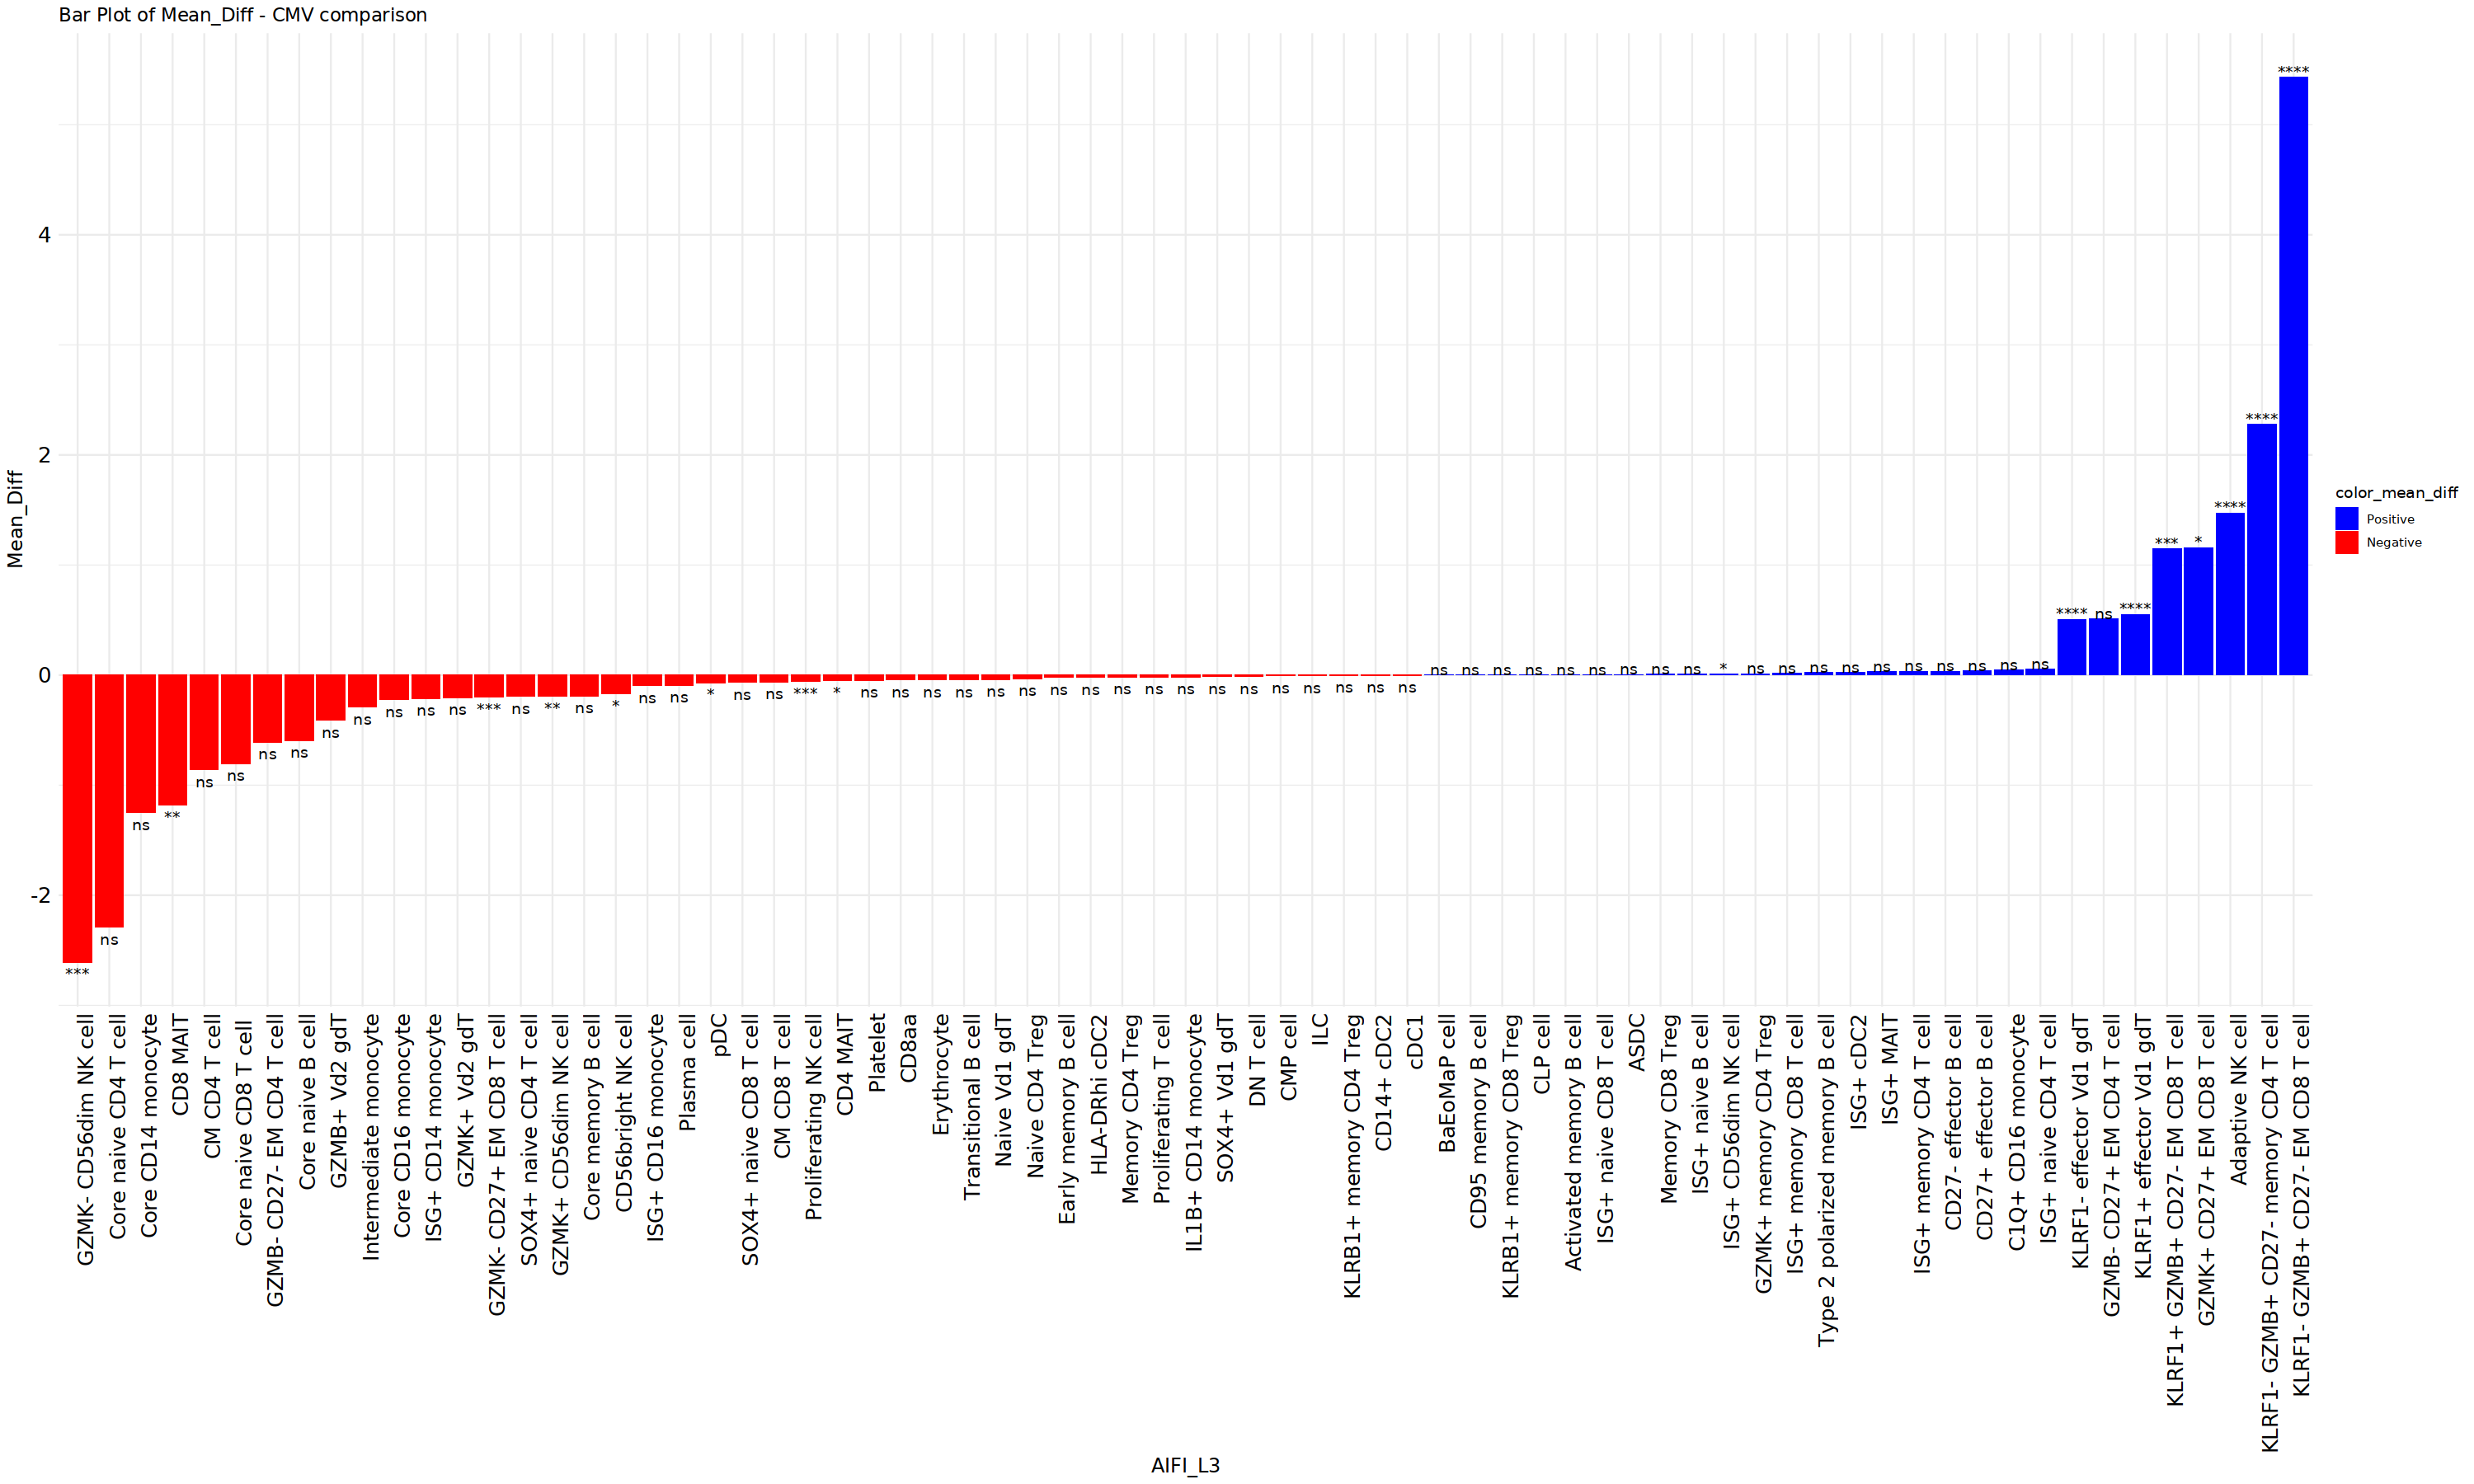

In [81]:
#Mean_Plot - CMV
library(ggplot2)

# Create a new column for color based on Mean_Diff
merged_df$color_mean_diff <- ifelse(result_df$Mean_Diff >= 0, "Positive", "Negative")

options(repr.plot.width = 25, repr.plot.height = 15)
p <- ggplot(merged_df, aes(x = reorder(AIFI_L3, desc(-Mean_Diff)), y = Mean_Diff, fill = color_mean_diff)) +
  geom_bar(stat = "identity") +
  labs(title = "Bar Plot of Mean_Diff - CMV comparison",
       x = "AIFI_L3",
       y = "Mean_Diff") +
  scale_fill_manual(values = c("Positive" = "blue", "Negative" = "red"),
                    breaks = c("Positive", "Negative"),
                    labels = c("Positive", "Negative")) +
  theme_minimal() +
  theme(axis.text.x = element_text(angle = 90, hjust = 1))+
  #coord_flip()+
  theme_minimal() +
  theme(strip.text = element_text(size = 15),
                axis.text.x = element_text(color = "black",
                                           size = 15,
                                           angle = 90,
                                           hjust = 1,
                                           vjust = 1),
                axis.text.y = element_text(color = "black", size = 15),
                axis.title.x = element_text(size = 14),  # Adjust the font size of x-axis title
                axis.title.y = element_text(size = 14))


# Add p-values to the plot using geom_text
p + geom_text(aes(label = p.adj.signif), 
              vjust = ifelse(merged_df$Mean_Diff >= 0, 0, 1.5), 
              size = 4)


In [41]:
head(merged_df)

,AIFI_L3,BR1,BR2,Median_Diff,log2FC,.y.,group1,group2,n1,n2,statistic,p,p.adj,p.adj.signif,color_median_diff
,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<chr>,<chr>,<int>,<int>,<dbl>,<dbl>,<dbl>,<chr>,<chr>
1,Activated memory B cell,0.023160211,0.022930922,0.0002292887,0.01435401,percentage_clr,BR1,BR2,41,36,741,0.98000,0.98000000,ns,High_in_BR1
2,Adaptive NK cell,0.134476383,0.413793103,-0.2793167209,-1.62155678,percentage_clr,BR1,BR2,47,45,679,0.00287,0.01358467,*,High_in_BR2
3,ASDC,0.023009664,0.021580560,0.0014291038,0.09250760,percentage_clr,BR1,BR2,45,41,871,0.66100,0.76936066,ns,High_in_BR1
4,BaEoMaP cell,0.005886508,0.009093499,-0.0032069907,-0.62742342,percentage_clr,BR1,BR2,27,20,168,0.02800,0.09940000,ns,High_in_BR2
5,C1Q+ CD16 monocyte,0.184684388,0.243664717,-0.0589803298,-0.39983545,percentage_clr,BR1,BR2,47,45,799,0.04350,0.14707143,ns,High_in_BR2
6,CD14+ cDC2,0.350858819,0.370430677,-0.0195718579,-0.07831295,percentage_clr,BR1,BR2,47,45,939,0.35800,0.52954167,ns,High_in_BR2


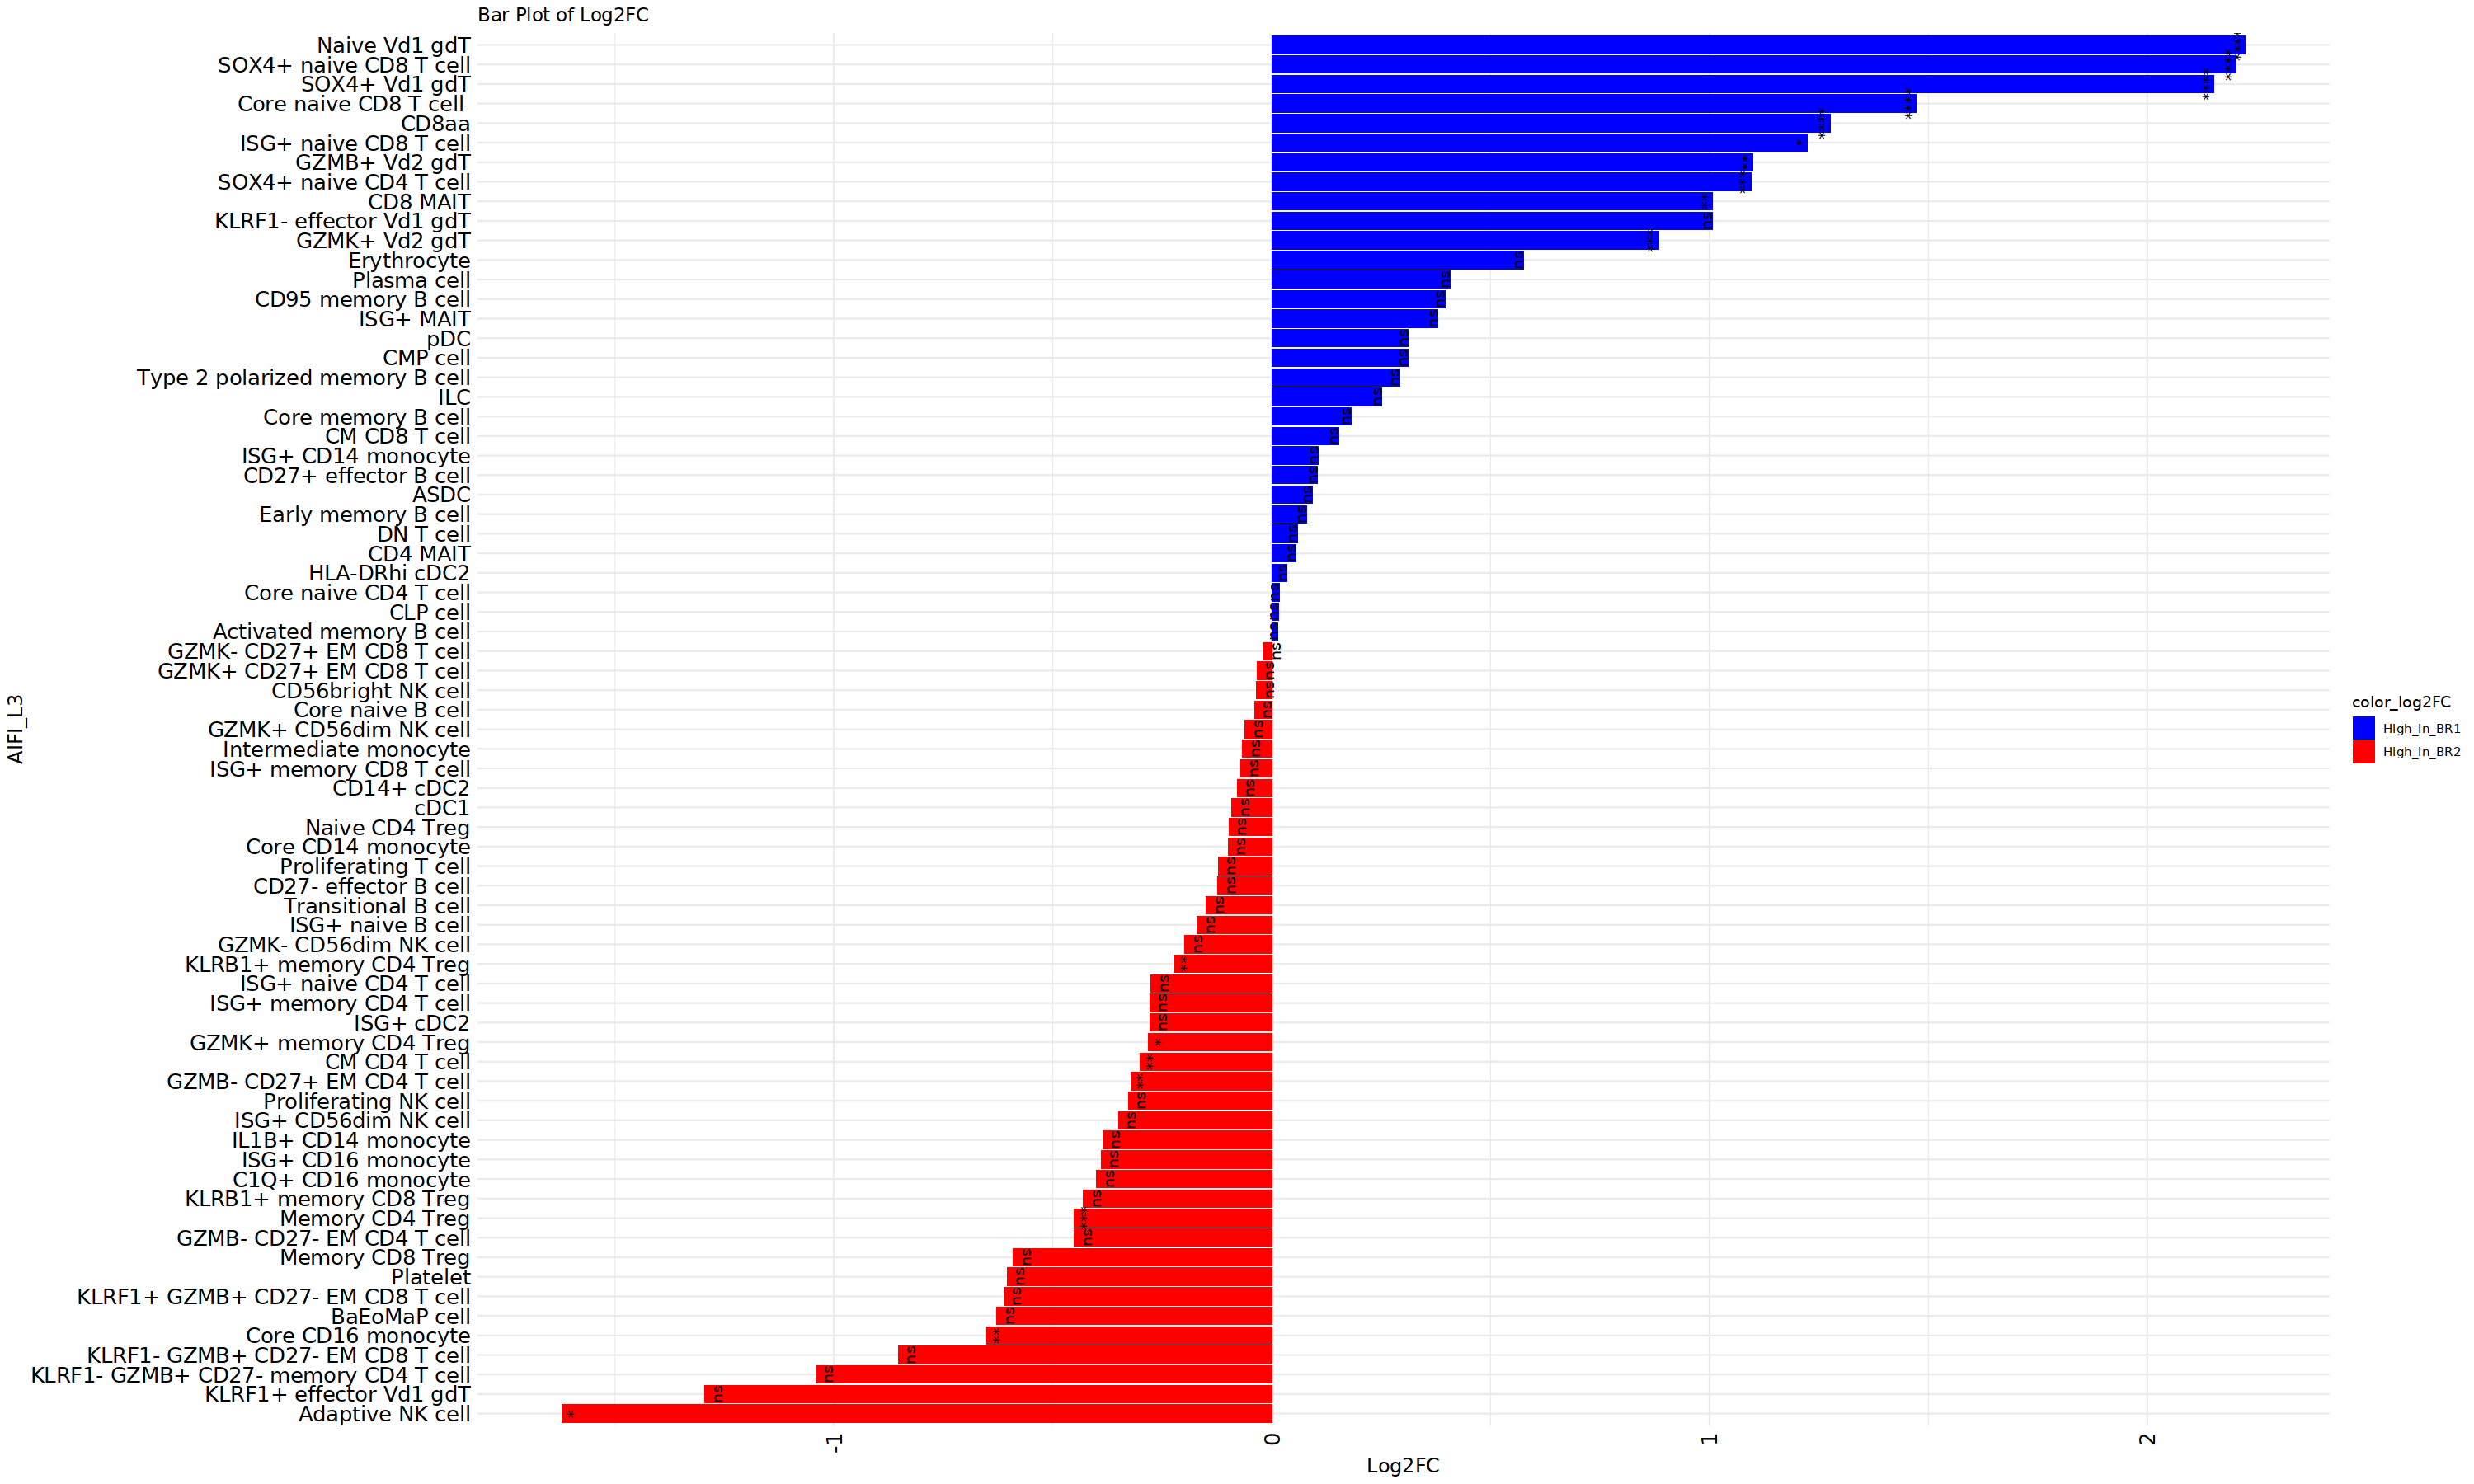

In [49]:

#Log2FC code: Age

library(ggplot2)


merged_df$color_log2FC <- ifelse(result_df$log2FC >= 0, "High_in_BR1", "High_in_BR2")

options(repr.plot.width = 25, repr.plot.height = 15)
p <- ggplot(merged_df, aes(x = reorder(AIFI_L3, desc(-log2FC)), y = log2FC, fill = color_log2FC)) +
  geom_bar(stat = "identity") +
  labs(title = "Bar Plot of Log2FC",
       x = "AIFI_L3",
       y = "Log2FC") +
  scale_fill_manual(values = c("High_in_BR1" = "blue", "High_in_BR2" = "red"),
                    breaks = c("High_in_BR1", "High_in_BR2"),
                    labels = c("High_in_BR1", "High_in_BR2")) +
  theme_minimal() +
  theme(axis.text.x = element_text(angle = 90, hjust = 1))+
  #coord_flip()+
  #theme_minimal() +
  theme(strip.text = element_text(size = 15),
                axis.text.x = element_text(color = "black",
                                           size = 15,
                                           angle = 90,
                                           hjust = 1,
                                           vjust = 0.5),
                axis.text.y = element_text(color = "black", size = 15),
                axis.title.x = element_text(size = 14),  # Adjust the font size of x-axis title
                axis.title.y = element_text(size = 14))




# Add p-values to the plot using geom_text
p + geom_text(aes(label = p.adj.signif), 
              vjust = ifelse(merged_df$log2FC >= 0, 0, 1.5),
              size = 4, angle = 90) 


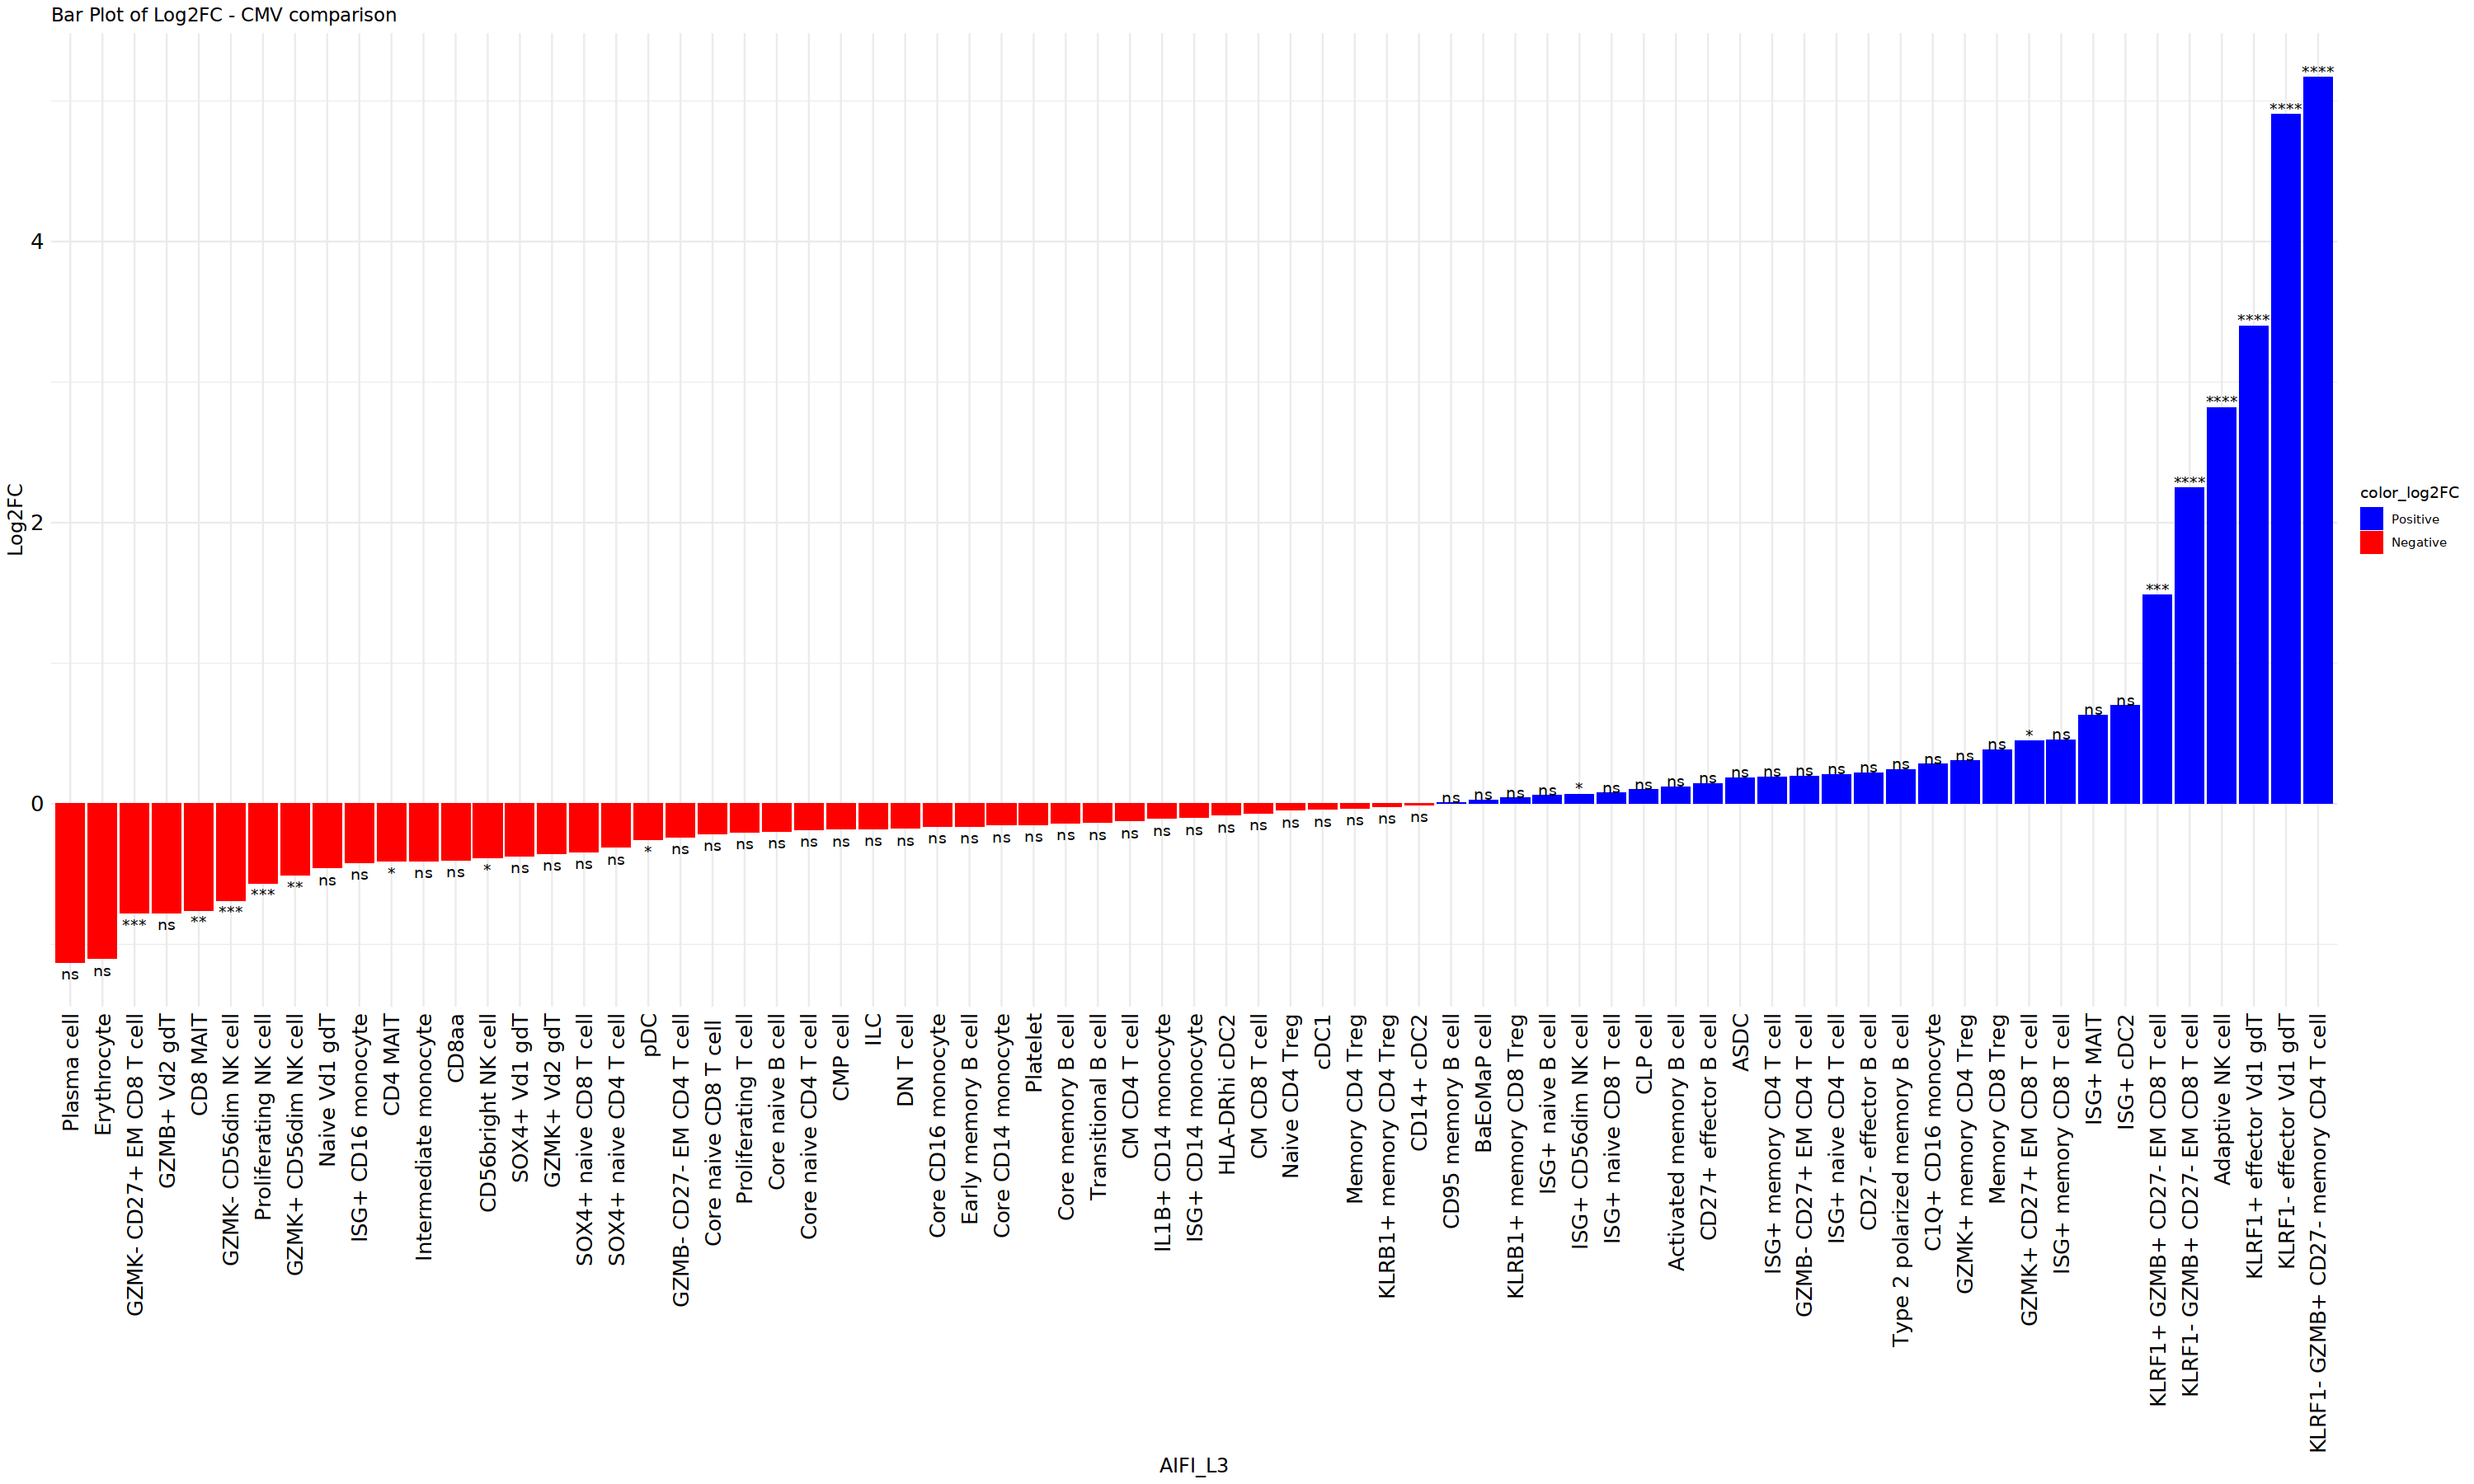

In [82]:

#Log2FC code: CMV

library(ggplot2)


merged_df$color_log2FC <- ifelse(result_df$log2FC >= 0, "Positive", "Negative")

options(repr.plot.width = 25, repr.plot.height = 15)
p <- ggplot(merged_df, aes(x = reorder(AIFI_L3, desc(-log2FC)), y = log2FC, fill = color_log2FC)) +
  geom_bar(stat = "identity") +
  labs(title = "Bar Plot of Log2FC - CMV comparison",
       x = "AIFI_L3",
       y = "Log2FC") +
  scale_fill_manual(values = c("Positive" = "blue", "Negative" = "red"),
                    breaks = c("Positive", "Negative"),
                    labels = c("Positive", "Negative")) +
  theme_minimal() +
  theme(axis.text.x = element_text(angle = 90, hjust = 1))+
  #coord_flip()+
  #theme_minimal() +
  theme(strip.text = element_text(size = 15),
                axis.text.x = element_text(color = "black",
                                           size = 15,
                                           angle = 90,
                                           hjust = 1,
                                           vjust = 0.5),
                axis.text.y = element_text(color = "black", size = 15),
                axis.title.x = element_text(size = 14),  # Adjust the font size of x-axis title
                axis.title.y = element_text(size = 14))




# Add p-values to the plot using geom_text
p + geom_text(aes(label = p.adj.signif), 
              vjust = ifelse(merged_df$log2FC >= 0, 0, 1.5),
              size = 4, angle = 0) 


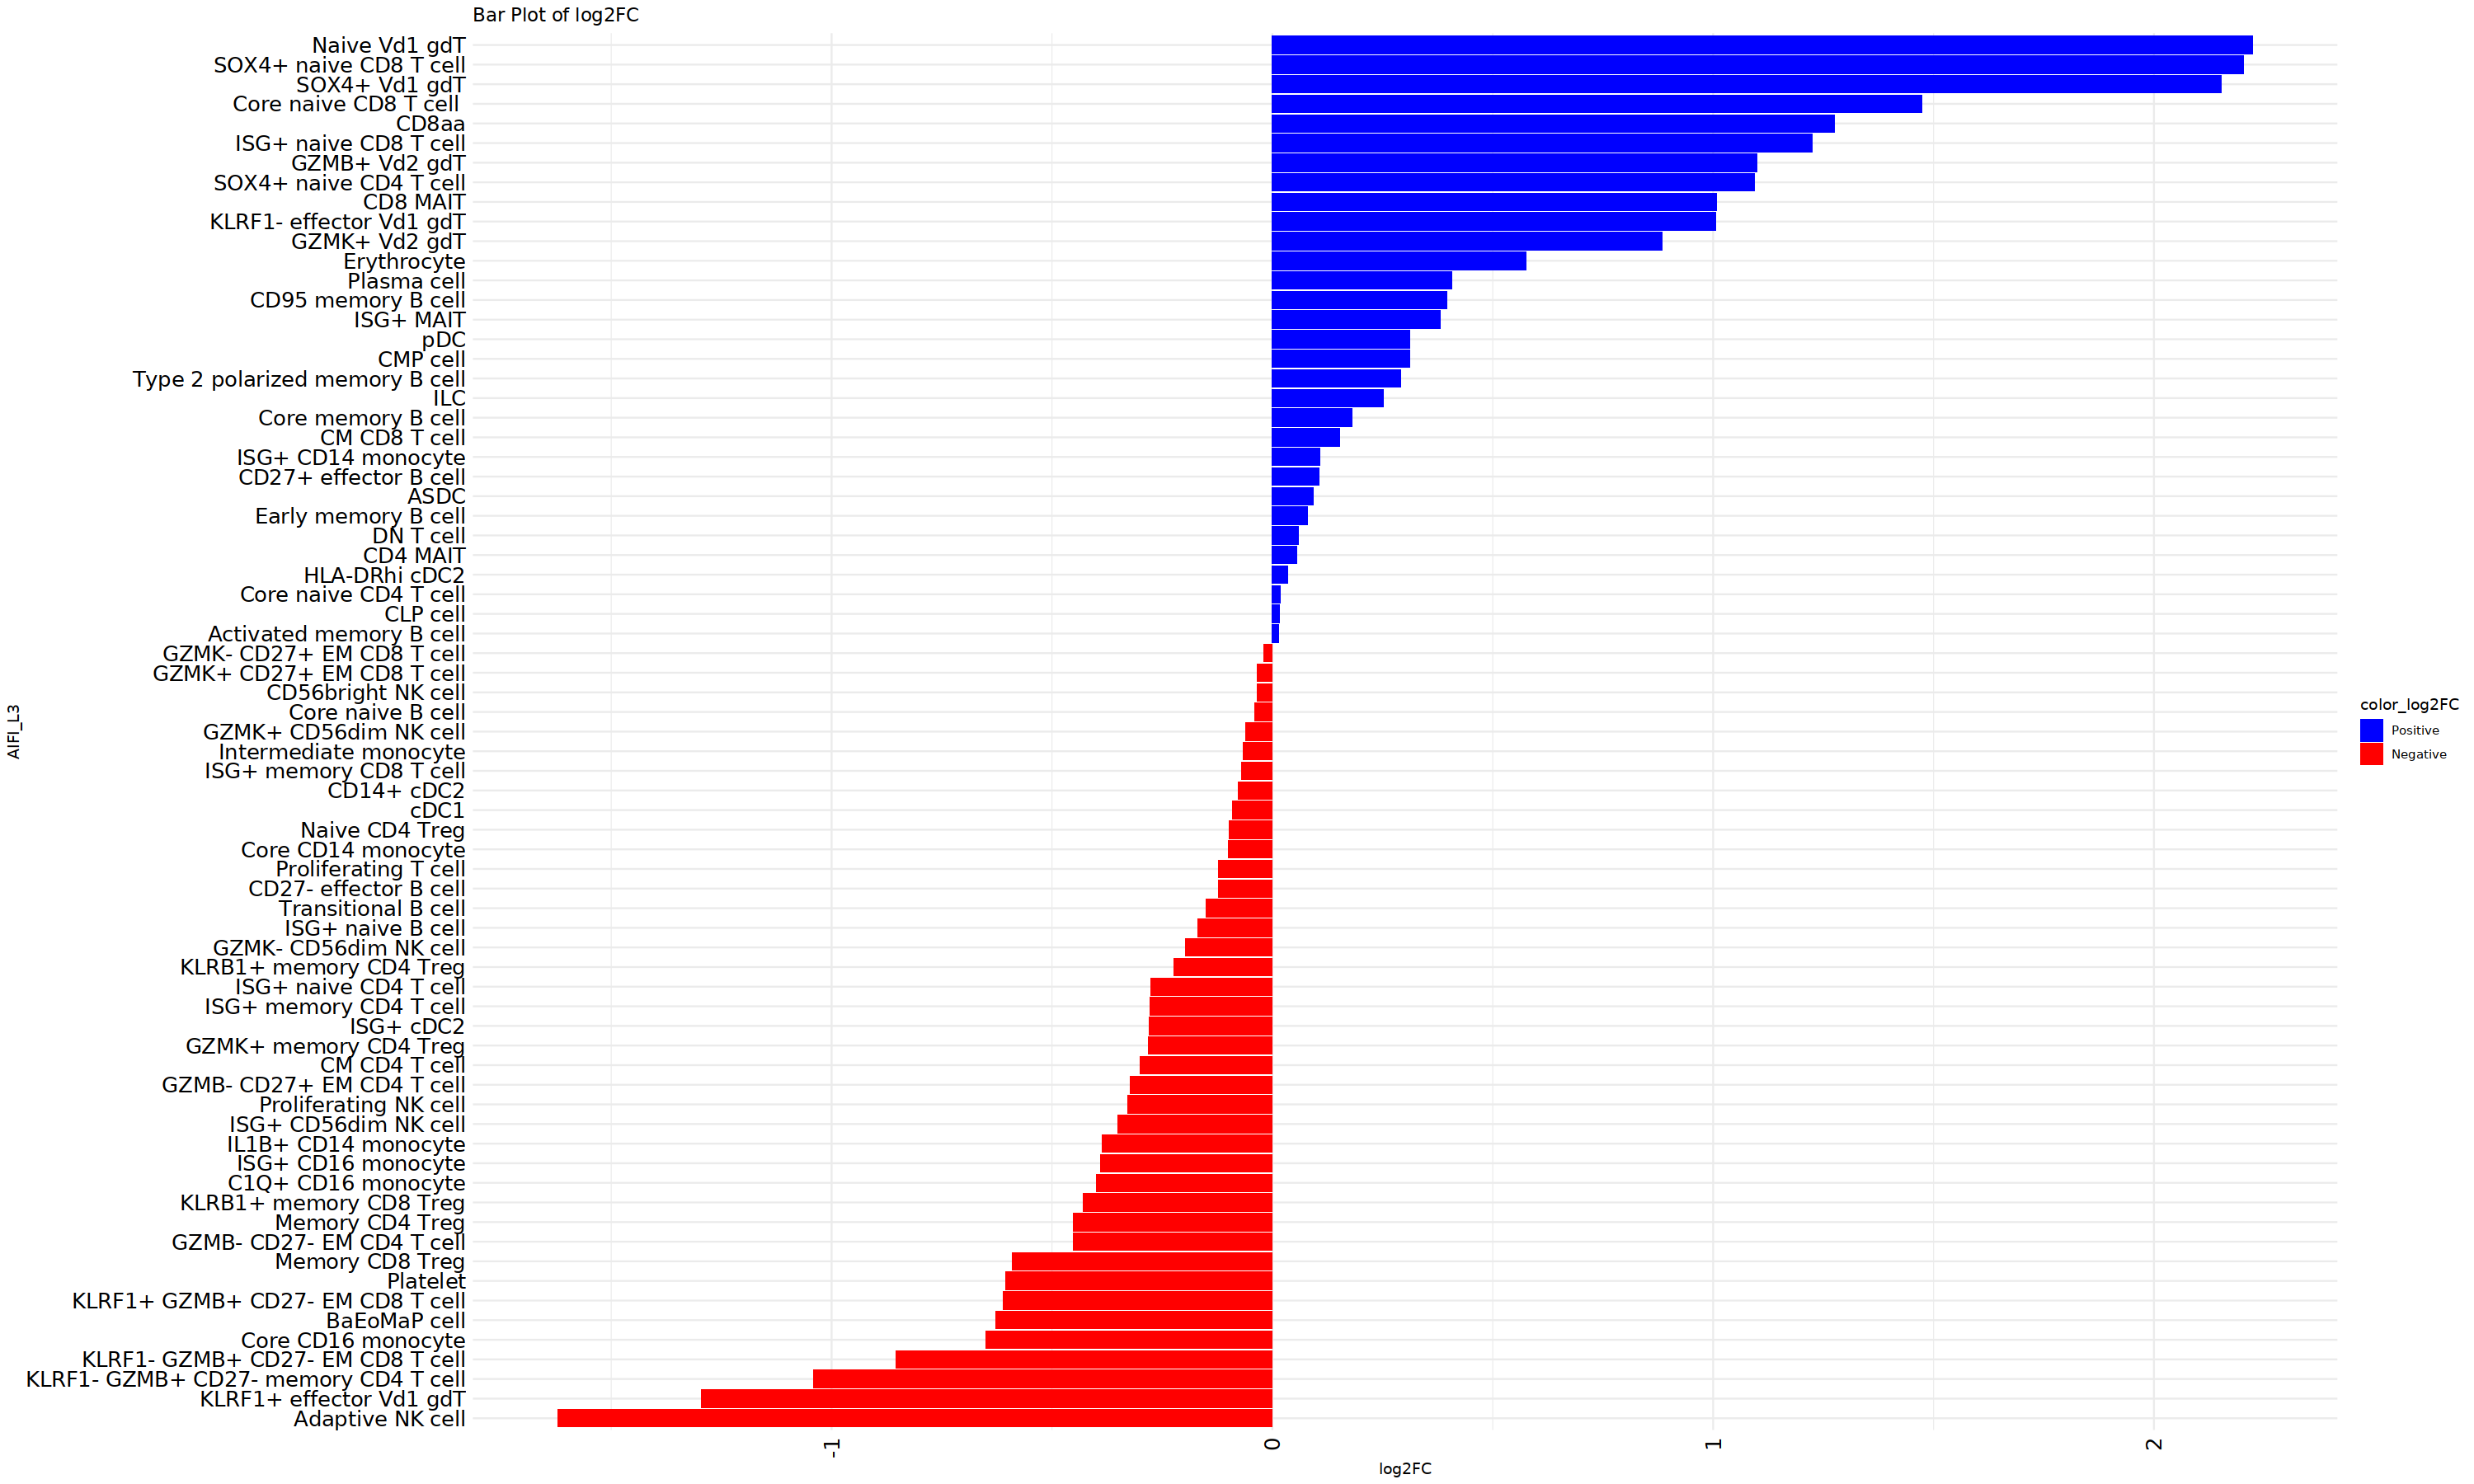

In [42]:
# Assuming your data frame is named 'your_df'
# Install and load the ggplot2 package if you haven't already
# install.packages("ggplot2")
library(ggplot2)

# Create a new column for color based on Mean_Diff
result_df$color_log2FC <- ifelse(result_df$log2FC >= 0, "Positive", "Negative")

# Plot the bar graph with different colors for positive and negative Mean_Diff
ggplot(result_df, aes(x = reorder(AIFI_L3, desc(-log2FC)), y = log2FC, fill = color_log2FC)) +
  geom_bar(stat = "identity") +
  labs(title = "Bar Plot of log2FC",
       x = "AIFI_L3",
       y = "log2FC") +
  scale_fill_manual(values = c("Positive" = "blue", "Negative" = "red"),
                    breaks = c("Positive", "Negative"),
                    labels = c("Positive", "Negative")) +
coord_flip()+
  theme_minimal() +
  theme(strip.text = element_text(size = 15),
                axis.text.x = element_text(color = "black",
                                           size = 15,
                                           angle = 90,
                                           hjust = 1,
                                           vjust = 0.5),
                axis.text.y = element_text(color = "black", size = 15))# Rotate x-axis labels for better visibility


In [ ]:
options(repr.plot.width = 16, repr.plot.height = 20)
result_df$Mean_Diff2 <- ifelse(result_df$cohort.cohortGuid == "BR1", -1 * result_df$Mean_Diff, result_df$Mean_Diff)

library(ggplot2)
ggplot(data = result_df) + geom_bar(aes(x = reorder(AIFI_L3, desc(-Mean_Diff)), y = Mean_Diff2, fill = cohort.cohortGuid), stat = "identity", position = "identity") +
                        #geom_text(aes(x=AIFI_L3,y=Mean_Diff2,label=abs(Mean_Diff2)),vjust = ifelse(result_df$Mean_Diff2 >= 0, 0, 1)) +
                        coord_flip()+
                        scale_y_continuous(labels=abs)+
                         theme(strip.text = element_text(size = 15),
                axis.text.x = element_text(color = "black",
                                           size = 15,
                                           angle = 90,
                                           hjust = 1,
                                           vjust = 0.5),
                axis.text.y = element_text(color = "black", size = 15))+
                xlab("AIFI_L3") +
                ylab("Mean Difference")

In [ ]:
# Assuming your data frame is named 'original_df'
# Install and load the dplyr package if you haven't already
# install.packages("dplyr")
library(dplyr)

# Group by 'AIFI_L3' and create a new data frame with mean_diff values for each 'cohort.cohortGuid'
result_df <- result_df %>%
  dplyr::group_by(AIFI_L3, cohort.cohortGuid) %>%
  dplyr::summarise(Mean_Diff = first(Mean_Diff)) %>%
  tidyr::spread(cohort.cohortGuid, Mean_Diff)

# Print the result data frame
print(result_df)



In [ ]:
# Assuming your result data frame is named 'result_df'
# Install and load the ggplot2 package if you haven't already
# install.packages("ggplot2")
library(ggplot2)

# Melt the data frame for easier plotting
melted_df <- reshape2::melt(result_df, id.vars = "AIFI_L3")

# Create a bidirectional bar graph
ggplot(melted_df, aes(x = AIFI_L3, y = value, fill = variable)) +
  geom_bar(stat = "identity", position = "identity", width = 0.7) +
  coord_flip() +  # Flip the coordinates to make it bidirectional
  labs(title = "Bidirectional Bar Graph",
       x = "AIFI_L3",
       y = "Mean_Diff") +
  theme_minimal()



# Calculating the log2FC of Percentage

In [ ]:
## Percentage of total

result <- myeloid_df %>%
  dplyr::group_by(AIFI_L3, subject.subjectGuid ) %>%               
  dplyr::summarise(count = n()) %>%                  # Count occurrences
  dplyr::group_by(subject.subjectGuid) %>%                       
  dplyr::mutate(percentage = (count / sum(count)) * 100) %>% 
  dplyr::group_by(subject.subjectGuid) %>%     
  dplyr::mutate(percentage_clr = clr_transform((percentage))) %>% # Group again by subjectGuid for CLR# Calculate percentage
  dplyr::ungroup()

head(result)
#sum(result$subject.subjectGuid)

In [ ]:
result %>% filter(subject.subjectGuid == "BR1001") %>% 
      select(percentage) %>%
      pull() %>% 
      sum()

In [ ]:
result<-left_join(result,unique(myeloid_df[c('cohort.cohortGuid','subject.subjectGuid','subject.biologicalSex','CMV.IgG.Serology.Result.Interpretation')]),by=c('subject.subjectGuid'))

In [ ]:
head(result)

In [ ]:
# library(dplyr)

# # Assuming your data frame is named 'your_data'
# result_df <- result %>%
#   dplyr::group_by(AIFI_L3, cohort.cohortGuid, CMV.IgG.Serology.Result.Interpretation) %>%
#   dplyr::summarise(mean_percentage = mean(percentage)) %>%
#   tidyr::pivot_wider(names_from = CMV.IgG.Serology.Result.Interpretation, values_from = mean_percentage) %>%
#   dplyr::mutate(Mean_Diff_BR1 = Positive - Negative,
#          Mean_Diff_BR2 = Positive - Negative) %>%
#   dplyr::select(AIFI_L3, cohort.cohortGuid, Mean_Diff_BR1, Mean_Diff_BR2)

# # Print the result
# print(result_df)


In [ ]:
library(dplyr)
library(tidyr)

# Assuming your data frame is named 'your_data'
result_log <- result %>%
  dplyr::group_by(AIFI_L3, CMV.IgG.Serology.Result.Interpretation, cohort.cohortGuid) %>%
  dplyr::summarise(mean_percentage = mean(percentage)) 

# Print the result
print(result_log)

In [ ]:
result_log <- result_log %>% spread(CMV.IgG.Serology.Result.Interpretation, mean_percentage)

In [ ]:
head(result_log)

In [ ]:
result_log <- result_log %>%  mutate(log2FC = abs(log2((Positive)/(Negative))))

In [ ]:
head(result_log)

In [ ]:
options(repr.plot.width = 15, repr.plot.height = 16)
result_log$log2FC_v2 <- ifelse(result_log$cohort.cohortGuid == "BR1", -1 * result_log$log2FC, result_log$log2FC)

library(ggplot2)
ggplot(data = result_log) + geom_bar(aes(x = reorder(AIFI_L3, desc(-log2FC)), y = log2FC_v2, fill = cohort.cohortGuid), stat = "identity", position = "identity") +
                        #geom_text(aes(x=AIFI_L3,y=Mean_Diff2,label=abs(Mean_Diff2)),vjust = ifelse(result_df$Mean_Diff2 >= 0, 0, 1)) +
                        coord_flip()+
                        scale_y_continuous(labels=abs)+
                        theme(strip.text = element_text(size = 15),
                axis.text.x = element_text(color = "black",
                                           size = 15,
                                           angle = 90,
                                           hjust = 1,
                                           vjust = 0.5),
                axis.text.y = element_text(color = "black", size = 15))+
                xlab("AIFI_L3") +
                ylab("Log2FC")

# Calculating the log2FC and mean difference

In [ ]:
stat_test<- result %>%
  select(percentage, AIFI_L3, cohort.cohortGuid, CMV.IgG.Serology.Result.Interpretation) %>%
  unique(.) %>%
  group_by(AIFI_L3, CMV.IgG.Serology.Result.Interpretation) %>%
  wilcox_test(percentage ~ cohort.cohortGuid) %>%
  adjust_pvalue(method = "BH") %>%
  add_significance()

In [ ]:
head(stat_test)

In [ ]:
stat_test$log2FC <- log2(result$percentage[result$cohort.cohortGuid == "BR1"] / result$percentage[result$cohort.cohortGuid == "BR2"])

In [ ]:
#New column for log2FC
result$log2FC <- NA

# Calculate log2FC only for rows where the cohort is either "BR1" or "BR2"
subset_rows <- result$cohort.cohortGuid %in% c("BR1", "BR2")

# Calculate log2FC for the valid rows
result$log2FC[subset_rows] <- log2(result$percentage[subset_rows & result$cohort.cohortGuid == "BR1"] / 
                                           result$percentage[subset_rows & result$cohort.cohortGuid == "BR2"])


In [ ]:
head(result)

In [ ]:
result_cohort$log2FC <- 


In [ ]:
# Percentage comparing Age across CMV

#result_cohort <- result[result$CMV.IgG.Serology.Result.Interpretation == 'Negative', ]
result_cohort <- result[result$CMV.IgG.Serology.Result.Interpretation == 'Positive', ]

stat_test<- result_cohort %>%
  select(percentage, AIFI_L3, cohort.cohortGuid, CMV.IgG.Serology.Result.Interpretation) %>%
  unique(.) %>%
  group_by(AIFI_L3, CMV.IgG.Serology.Result.Interpretation) %>%
  wilcox_test(percentage ~ cohort.cohortGuid) %>%
  adjust_pvalue(method = "BH") %>%
  add_significance()


# Create the plot
options(repr.plot.width = 35, repr.plot.height = 12)
p4 <- ggplot(result_cohort, aes(x = reorder(AIFI_L3, desc(percentage)) , y = percentage, color = cohort.cohortGuid)) +
  geom_boxplot(width = .5, outlier.shape = '.') +
  scale_x_discrete(name ="AIFI_L3", guide = guide_axis(angle = 90)) +
  theme_bw(base_size = 12) +
  geom_pwc(
    aes(group = cohort.cohortGuid),
    tip.length = 0, p.adjust.method = "BH",
    method = "wilcox_test", label ="p= {p.adj} {p.signif}", angle = 90, hide.ns = FALSE  # or "panel"
  ) +
  #facet_grid(cohort.cohortGuid ~ ., scales = "free_y", space = "free_y") +
  scale_y_continuous(expand = expansion(mult = c(0.05, 0.15))) +
  theme(axis.text.x = element_text(size = 16, color = "black", angle = 90, hjust = 0.5, vjust = 0.5),
        axis.text.y = element_text(size = 16, color = "black"),
        axis.title.x = element_text(size = 16, color = "black"),
        axis.title.y = element_text(size = 16, color = "black"))

# Display the plot
print(p4)


In [ ]:
head(result)

In [ ]:
# Create a bidirectional plot
ggplot(result, aes(x = AIFI_L3, y = log2FC, color = group)) +
  geom_segment(aes(x = -Inf, xend = Inf, yend = y), linetype = "dashed") +
  geom_point() +
  theme_minimal()

In [ ]:
#stat.test
stat.test$AdjP = round(p.adjust(stat.test$p, 'BH'),3)

stat.test %>% head()
tmp = left_join(NK_df, stat.test)
#ggplot(NK_df
head(tmp)

NK_df$PercentageCLR = NK_df$`.y`
ggplot(tmp, aes(x=AIFI_L3,
                y=PercentageCLR,
                fill=CMV.IgG.Serology.Result.Interpretation,
                label=AdjP))+geom_boxplot()+
        geom_text(mapping = aes(x=AIFI_L3,
                                y=max(PercentageCLR)+0.4))